In [2]:
% of certainty

i want null / no sign / shape / type

must make CNN from scratch e.g. like program each layer

mlp is baseline cnn is the final

hyperparameter tune the batch

design cnn better now

take images for test

try leakyrelu

softmax all the layers, etc. 

apply L1 + L2 regularization to CNN

dropouts

reduce input size

SyntaxError: invalid syntax (1751380093.py, line 3)

In [1]:
import tensorflow as tf
import numpy as np
np.object = np.object_
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  0
[]


<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 48px;"><strong>Assignment 2</strong></h1>
    <h2 style="color:#7D3C98;">Major Project</h2>
    <h2 style="color:#7D3C98;"><strong>COSC2673</strong> Machine Learning</h2>
    <h3 style="color:#D2B4DE; margin-top: 20px;">(Undergraduate Level)</h3>
    <h3 style="background: linear-gradient(to right, #7D3C98, #D7BDE2); -webkit-background-clip: text; color: solid;">By Oisin Aeonn & Vince Quach</em></h3>
    <h4 style="color:#BB8FCE;">Student IDs: s3952320 & s3900481</h4>
</div>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">1.3 Python Library Imports</h1>

In [2]:
# Operating system interfaces
import os

# Data manipulation and analysis
import pandas as pd

# Model selection and evaluation
from sklearn.model_selection import train_test_split

# Image preprocessing and augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Building sequential models
from tensorflow.keras.models import Sequential

# Layers for building neural networks
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Encoding categorical variables
from sklearn.preprocessing import LabelEncoder

# Plotting and visualization
import matplotlib.pyplot as plt

# Interactive and expressive visualizations
import plotly.express as px

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Numerical computing
import numpy as np

# Statistical data visualization
import seaborn as sns

# Debug
print(os.environ['PATH'])

plt.style.use('dark_background')

# Building functional models
from tensorflow.keras.models import Model

# Additional layers for neural networks
from tensorflow.keras.layers import Dropout, Input


from PIL import Image

import imageio
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import tensorflow as tf

import numpy as np
import pandas as pd
import os
import imageio
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from skimage import transform
from skimage.color import rgb2gray, gray2rgb

/opt/anaconda/bin:/opt/anaconda/condabin:/usr/local/sbin:/usr/local/bin:/usr/bin:/var/lib/flatpak/exports/bin:/usr/lib/jvm/default/bin:/usr/bin/site_perl:/usr/bin/vendor_perl:/usr/bin/core_perl:/var/lib/snapd/snap/bin


<h5 style="color:#D2B4DE; margin-top: 20px;">
    <ul>
        <li>First, let's cover all of the required imports for this entire Jupyter Notebook.</li><br>
        <li>I put them all here so that you can run most cells (especially EDA) out of order.</li><br>
        <li>This also conforms to the coding standard DO NOT REPEAT YOURSELF (DRY).</li><br>
        <li>I also have provided a commented description of each library for their use.</li><br>
    </ul>
</h5>

# EDA

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">2.0 Data Ingestion</h1>

In [3]:
# Custom preprocessing function
def preprocess_input(x):
    return x / 255.0

In [4]:
# Set the path to your dataset and define the image size
dataset_path = 'trafficsigns_dataset'
img_size = (28, 28)

In [5]:
# Create lists to store the image paths, shapes, and types
image_paths = []
shapes = []
types = []

In [6]:
for shape in os.listdir(dataset_path):
    shape_path = os.path.join(dataset_path, shape)
    for sign_type in os.listdir(shape_path):
        type_path = os.path.join(shape_path, sign_type)
        for image_file in os.listdir(type_path):
            image_path = os.path.join(type_path, image_file)
            image_paths.append(image_path)
            shapes.append(shape)
            types.append(sign_type)

# Encode the shape and type labels
shape_encoder = LabelEncoder()
type_encoder = LabelEncoder()

shape_labels = shape_encoder.fit_transform(shapes)
type_labels = type_encoder.fit_transform(types)

# Create a DataFrame with image paths, shape labels, and type labels
df = pd.DataFrame({
    'image_path': image_paths,
    'shape_label': shape_labels,
    'type_label': type_labels
})

In [7]:
# Print the first 3 rows of the DataFrame
df.info()

df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3699 entries, 0 to 3698
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_path   3699 non-null   object
 1   shape_label  3699 non-null   int64 
 2   type_label   3699 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 86.8+ KB


,image_path,shape_label,type_label
0,trafficsigns_dataset/hex/stop/00684_00002.png,1,12
1,trafficsigns_dataset/hex/stop/00685_00002.png,1,12
2,trafficsigns_dataset/hex/stop/00478_00001.png,1,12


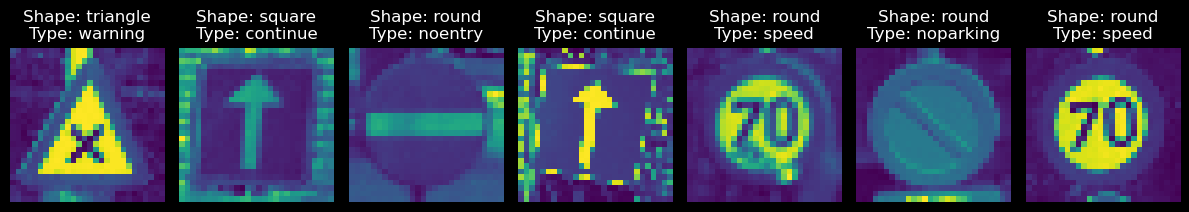

In [8]:
# Display a few randomly selected images with their labels
num_images = 7
random_indices = df.index.to_series().sample(num_images)

fig, axes = plt.subplots(1, num_images, figsize=(12, 4))

for i, idx in enumerate(random_indices):
    image_path = df.loc[idx, 'image_path']
    shape_label = shape_encoder.inverse_transform([df.loc[idx, 'shape_label']])[0]
    type_label = type_encoder.inverse_transform([df.loc[idx, 'type_label']])[0]
    
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].set_title(f"Shape: {shape_label}\nType: {type_label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [9]:
# Check if there are any duplicated rows in the DataFrame
has_duplicates = df.duplicated().any()

# Print out the result
print(f"DuplicateData: {has_duplicates}")

DuplicateData: False


Number of image files found: 3699


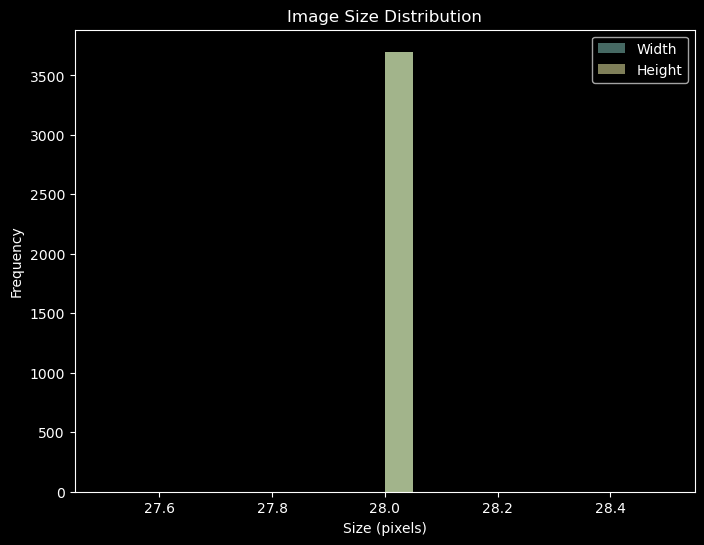

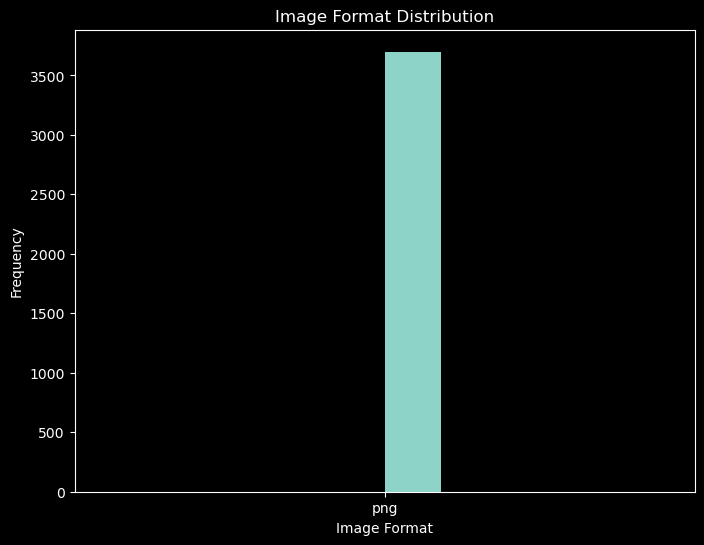

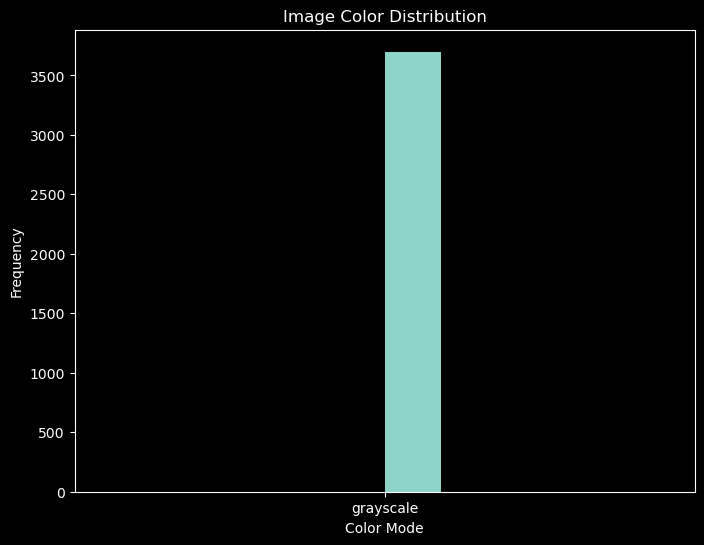

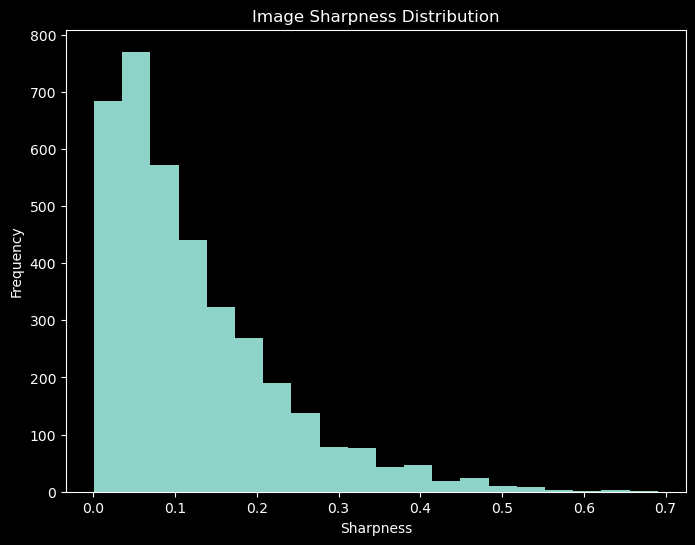

In [57]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters

# Directory containing the image dataset
dataset_dir = 'trafficsigns_dataset'

# Function to get all image files in subdirectories
def get_image_files(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(os.path.join(root, file))
    return image_files

# Get the list of image files
image_files = get_image_files(dataset_dir)

print("Number of image files found:", len(image_files))

# Initialize lists to store image properties
image_sizes = []
image_formats = []
image_colors = []
image_sharpness = []

# Iterate over the image files
for image_path in image_files:
    try:
        image = io.imread(image_path)
        
        # Get image size
        height, width = image.shape[:2]
        image_sizes.append((width, height))
        
        # Get image format
        image_format = os.path.splitext(image_path)[1][1:]
        image_formats.append(image_format)
        
        # Check if the image is grayscale or color
        if len(image.shape) == 2:
            image_colors.append('grayscale')
        else:
            image_colors.append('color')
        
        # Calculate image sharpness using the variance of the Laplacian
        sharpness = np.var(filters.laplace(image))
        image_sharpness.append(sharpness)
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")

# Plot image size distribution
plt.figure(figsize=(8, 6))
plt.hist([size[0] for size in image_sizes], bins=20, alpha=0.5, label='Width')
plt.hist([size[1] for size in image_sizes], bins=20, alpha=0.5, label='Height')
plt.xlabel('Size (pixels)')
plt.ylabel('Frequency')
plt.title('Image Size Distribution')
plt.legend()
plt.show()

# Plot image format distribution
plt.figure(figsize=(8, 6))
plt.hist(image_formats)
plt.xlabel('Image Format')
plt.ylabel('Frequency')
plt.title('Image Format Distribution')
plt.show()

# Plot image color distribution
plt.figure(figsize=(8, 6))
plt.hist(image_colors)
plt.xlabel('Color Mode')
plt.ylabel('Frequency')
plt.title('Image Color Distribution')
plt.show()

# Plot image sharpness distribution
plt.figure(figsize=(8, 6))
plt.hist(image_sharpness, bins=20)
plt.xlabel('Sharpness')
plt.ylabel('Frequency')
plt.title('Image Sharpness Distribution')
plt.show()

# Data Splitting

Number of images in the training set: 2959
Number of images in the validation set: 740


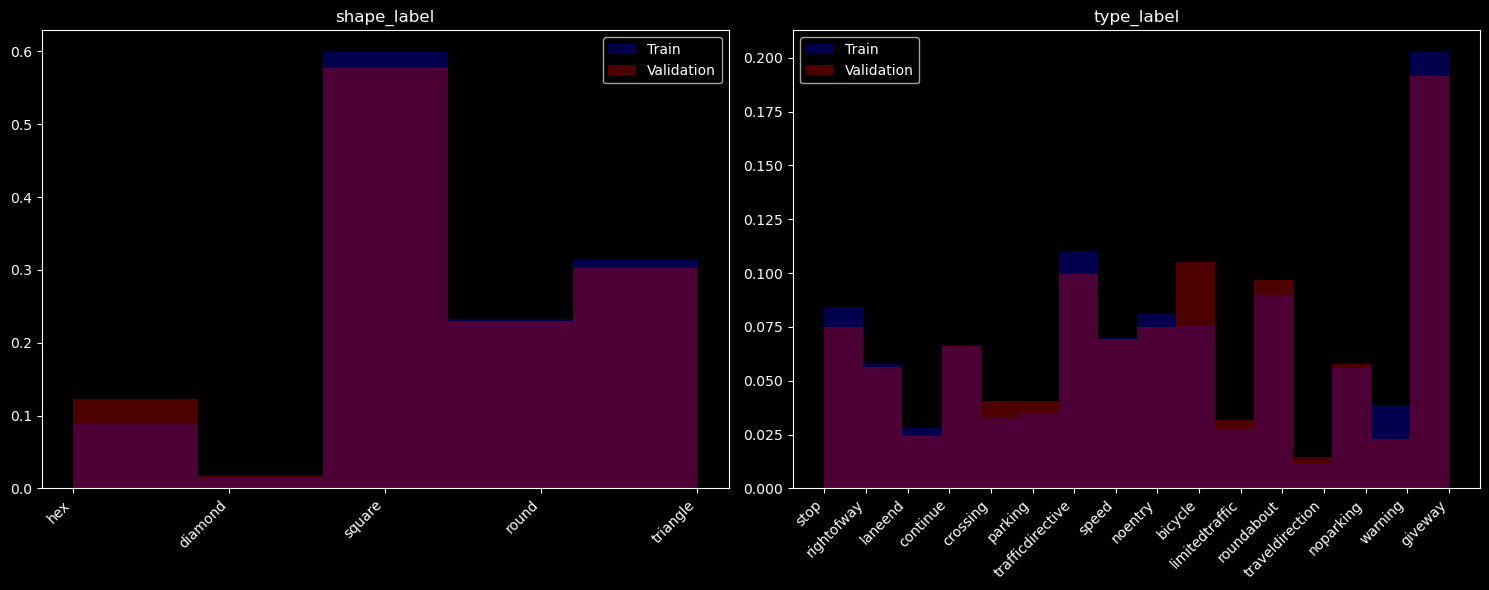

In [10]:
import matplotlib.pyplot as plt

# Split the data into train and validation sets
train_indices, val_indices = train_test_split(df.index, test_size=0.2, random_state=42)

# Print the number of items in each dataset
print("Number of images in the training set:", len(train_indices))
print("Number of images in the validation set:", len(val_indices))

# Create data generators for training and validation
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Get the unique labels for each column
shape_labels = shape_encoder.inverse_transform(df['shape_label'].unique())
type_labels = type_encoder.inverse_transform(df['type_label'].unique())

# Create a grid of subplots
plt.figure(figsize=(15, 6))
for i, col in enumerate(['shape_label', 'type_label']):
    plt.subplot(1, 2, i+1)
    if col == 'shape_label':
        unique_values = shape_labels
    else:
        unique_values = type_labels

    plt.hist(df.loc[train_indices, col], alpha=0.3, color='b', density=True,
             bins=len(unique_values), label='Train')
    plt.hist(df.loc[val_indices, col], alpha=0.3, color='r', density=True,
             bins=len(unique_values), label='Validation')
    plt.title(col)
    plt.xticks(range(len(unique_values)), unique_values, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()

plt.show()

# work in progress it recommends to do this.

In [13]:
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from PIL import Image

# Add a new column to the DataFrame with flattened image data as strings
df['image_data'] = df['image_path'].apply(lambda x: ' '.join(map(str, np.array(Image.open(x).resize((28, 28))).flatten())))

# Create the document-term matrix
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['image_data'])

# Apply LDA
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X)

# Print the topics
print("Topics:")
for topic_idx, topic in enumerate(lda.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]]))

Topics:
Topic #0:
44 43 42 45 41 40 46 39 47 38
Topic #1:
20 21 23 22 24 19 25 18 26 17
Topic #2:
119 117 120 114 116 118 115 124 121 112
Topic #3:
61 62 60 59 63 64 58 65 57 66
Topic #4:
75 72 74 73 76 71 77 78 70 79
Topic #5:
51 52 50 53 49 54 48 55 47 56
Topic #6:
255 254 253 252 251 103 102 101 104 109
Topic #7:
35 34 33 36 32 37 31 38 30 29
Topic #8:
88 90 93 91 89 92 87 94 86 185
Topic #9:
254 253 252 251 250 249 248 247 246 245


In [11]:
# Load and preprocess the image data
def load_and_preprocess_image(image_path):
    img = imageio.imread(image_path)
    img = img / 255.0
    return img.flatten()

# Prepare the input data and labels
X_train = np.array([load_and_preprocess_image(image_path) for image_path in df.iloc[train_indices]['image_path']])
X_val = np.array([load_and_preprocess_image(image_path) for image_path in df.iloc[val_indices]['image_path']])

y_train_shape = df.iloc[train_indices]['shape_label'].values
y_train_type = df.iloc[train_indices]['type_label'].values
y_val_shape = df.iloc[val_indices]['shape_label'].values
y_val_type = df.iloc[val_indices]['type_label'].values

# Regression Model

big difference here is this uses a sigmoid activiation function.

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression models for shape and type
shape_regressor = LinearRegression()
type_regressor = LinearRegression()

# Train the models
shape_regressor.fit(X_train, y_train_shape)
type_regressor.fit(X_train, y_train_type)

# Make predictions on the validation set
shape_pred = shape_regressor.predict(X_val)
type_pred = type_regressor.predict(X_val)

# Evaluate the models
shape_mse = mean_squared_error(y_val_shape, shape_pred)
shape_r2 = r2_score(y_val_shape, shape_pred)
type_mse = mean_squared_error(y_val_type, type_pred)
type_r2 = r2_score(y_val_type, type_pred)

print("Shape Regression:")
print("Mean Squared Error:", shape_mse)
print("R-squared:", shape_r2)

print("Type Regression:")
print("Mean Squared Error:", type_mse)
print("R-squared:", type_r2)

Shape Regression:
Mean Squared Error: 0.4426938531862882
R-squared: 0.6722807753180795
Type Regression:
Mean Squared Error: 9.941972029636986
R-squared: 0.5671614781106554


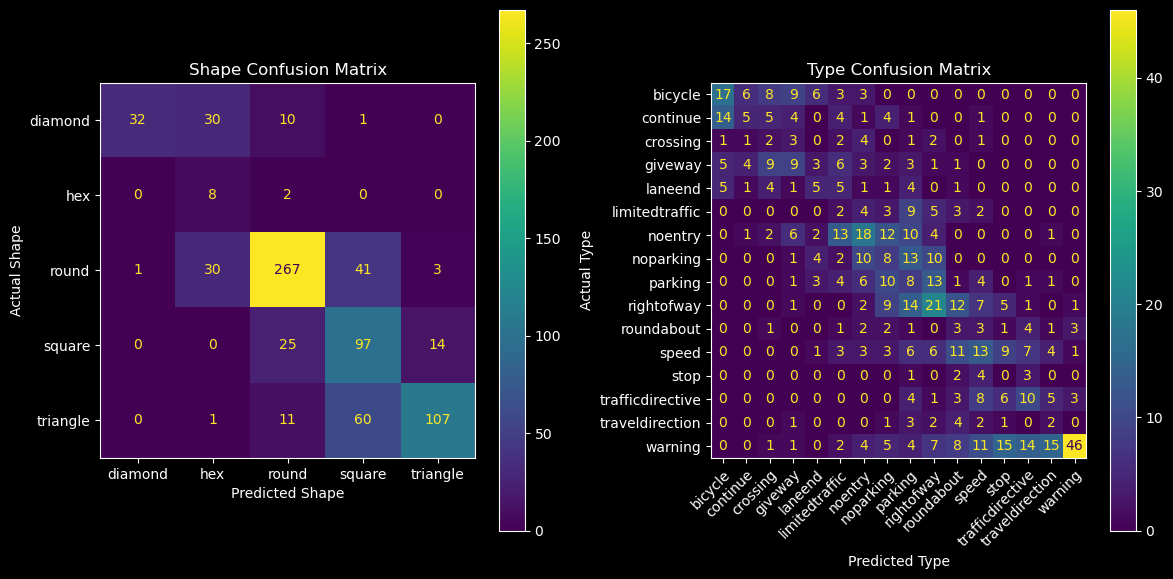

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Round the predicted values to the nearest integers
shape_pred_rounded = np.round(shape_pred).astype(int)
type_pred_rounded = np.round(type_pred).astype(int)

# Clip the rounded predictions to the valid range of encoded labels
shape_pred_clipped = np.clip(shape_pred_rounded, 0, len(shape_encoder.classes_) - 1)
type_pred_clipped = np.clip(type_pred_rounded, 0, len(type_encoder.classes_) - 1)

# Convert the clipped predictions to class labels
shape_pred_class = shape_encoder.inverse_transform(shape_pred_clipped)
type_pred_class = type_encoder.inverse_transform(type_pred_clipped)

# Create confusion matrices
shape_cm = confusion_matrix(shape_encoder.inverse_transform(y_val_shape), shape_pred_class)
type_cm = confusion_matrix(type_encoder.inverse_transform(y_val_type), type_pred_class)

# Plot the confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the confusion matrix for shape
shape_labels = shape_encoder.classes_
disp_shape = ConfusionMatrixDisplay(confusion_matrix=shape_cm, display_labels=shape_labels)
disp_shape.plot(ax=ax1)
ax1.set_title("Shape Confusion Matrix")
ax1.set_xlabel("Predicted Shape")
ax1.set_ylabel("Actual Shape")

# Plot the confusion matrix for type
type_labels = type_encoder.classes_
disp_type = ConfusionMatrixDisplay(confusion_matrix=type_cm, display_labels=type_labels)
disp_type.plot(ax=ax2)
ax2.set_title("Type Confusion Matrix")
ax2.set_xlabel("Predicted Type")
ax2.set_ylabel("Actual Type")

# Rotate the x-axis labels of the Type Confusion Matrix
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.show()

# Decision Tree

# from the shape then predict the type

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Create Decision Tree classifiers for shape and type
shape_dt = DecisionTreeClassifier(random_state=42)
type_dt = DecisionTreeClassifier(random_state=42)

# Perform GridSearchCV for shape classifier
shape_grid_search = GridSearchCV(shape_dt, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
shape_grid_search.fit(X_train, y_train_shape)

# Perform GridSearchCV for type classifier
type_grid_search = GridSearchCV(type_dt, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
type_grid_search.fit(X_train, y_train_type)

# Print the best parameters for shape classifier
print("Best Parameters for Shape Classifier:")
print(shape_grid_search.best_params_)

# Print the best parameters for type classifier
print("Best Parameters for Type Classifier:")
print(type_grid_search.best_params_)

Best Parameters for Shape Classifier:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Parameters for Type Classifier:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}


Shape Accuracy: 0.8635135135135135
Type Accuracy: 0.8364864864864865


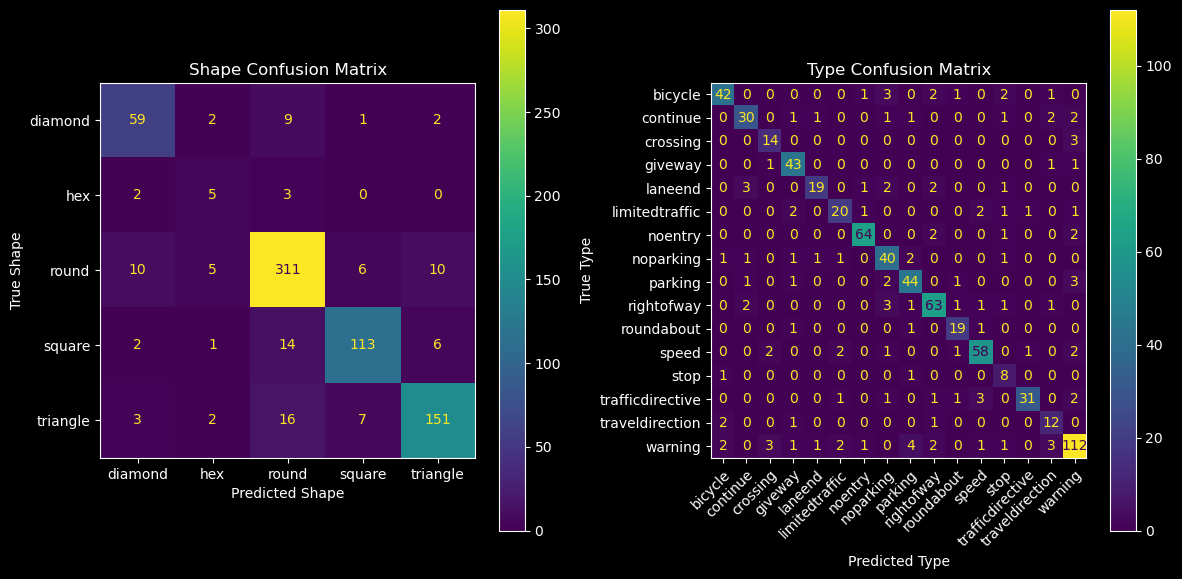

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create the hypertuned Decision Tree classifiers with the best parameters
shape_dt_best = DecisionTreeClassifier(**shape_grid_search.best_params_, random_state=42)
type_dt_best = DecisionTreeClassifier(**type_grid_search.best_params_, random_state=42)

# Train the hypertuned Decision Tree classifiers
shape_dt_best.fit(X_train, y_train_shape)
type_dt_best.fit(X_train, y_train_type)

# Make predictions on the validation set
shape_pred = shape_dt_best.predict(X_val)
type_pred = type_dt_best.predict(X_val)

# Evaluate the hypertuned Decision Tree classifiers on the validation set
shape_acc = shape_dt_best.score(X_val, y_val_shape)
type_acc = type_dt_best.score(X_val, y_val_type)

print("Shape Accuracy:", shape_acc)
print("Type Accuracy:", type_acc)

# Create confusion matrices
shape_cm = confusion_matrix(y_val_shape, shape_pred)
type_cm = confusion_matrix(y_val_type, type_pred)

# Plot the confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(shape_cm, display_labels=shape_encoder.classes_).plot(ax=ax1)
ax1.set_title("Shape Confusion Matrix")
ax1.set_xlabel("Predicted Shape")
ax1.set_ylabel("True Shape")

ConfusionMatrixDisplay(type_cm, display_labels=type_encoder.classes_).plot(ax=ax2)
ax2.set_title("Type Confusion Matrix")
ax2.set_xlabel("Predicted Type")
ax2.set_ylabel("True Type")

# Rotate the x-axis labels of the Type Confusion Matrix
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.show()

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">Random Forest</h1>

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create Random Forest classifiers for shape and type
shape_rf = RandomForestClassifier(random_state=42)
type_rf = RandomForestClassifier(random_state=42)

# Perform GridSearchCV for shape classifier
shape_grid_search = GridSearchCV(shape_rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
shape_grid_search.fit(X_train, y_train_shape)

# Perform GridSearchCV for type classifier
type_grid_search = GridSearchCV(type_rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
type_grid_search.fit(X_train, y_train_type)

# Print the best parameters for shape classifier
print("Best Parameters for Shape Classifier:")
print(shape_grid_search.best_params_)

# Print the best parameters for type classifier
print("Best Parameters for Type Classifier:")
print(type_grid_search.best_params_)

Best Parameters for Shape Classifier:
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Parameters for Type Classifier:
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


Shape Accuracy: 0.9540540540540541
Type Accuracy: 0.9594594594594594


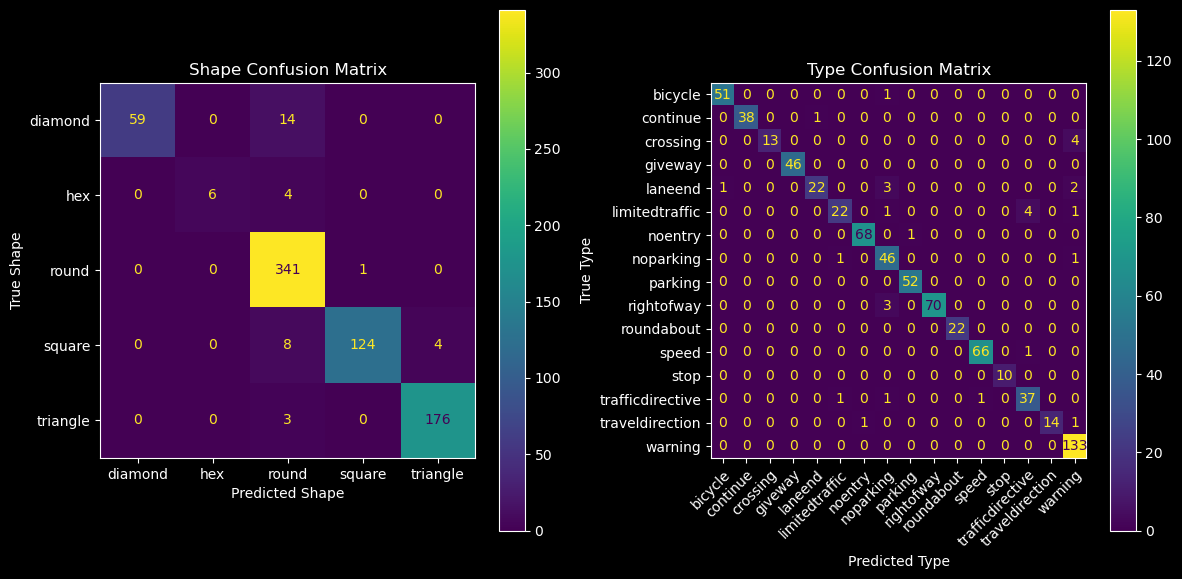

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create the hypertuned Random Forest classifiers with the best parameters
shape_rf_best = RandomForestClassifier(**shape_grid_search.best_params_, random_state=42)
type_rf_best = RandomForestClassifier(**type_grid_search.best_params_, random_state=42)

# Train the hypertuned Random Forest classifiers
shape_rf_best.fit(X_train, y_train_shape)
type_rf_best.fit(X_train, y_train_type)

# Make predictions on the validation set
shape_pred = shape_rf_best.predict(X_val)
type_pred = type_rf_best.predict(X_val)

# Evaluate the hypertuned Random Forest classifiers on the validation set
shape_acc = shape_rf_best.score(X_val, y_val_shape)
type_acc = type_rf_best.score(X_val, y_val_type)

print("Shape Accuracy:", shape_acc)
print("Type Accuracy:", type_acc)

# Create confusion matrices
shape_cm = confusion_matrix(y_val_shape, shape_pred)
type_cm = confusion_matrix(y_val_type, type_pred)

# Plot the confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(shape_cm, display_labels=shape_encoder.classes_).plot(ax=ax1)
ax1.set_title("Shape Confusion Matrix")
ax1.set_xlabel("Predicted Shape")
ax1.set_ylabel("True Shape")

ConfusionMatrixDisplay(type_cm, display_labels=type_encoder.classes_).plot(ax=ax2)
ax2.set_title("Type Confusion Matrix")
ax2.set_xlabel("Predicted Type")
ax2.set_ylabel("True Type")

# Rotate the x-axis labels of the Type Confusion Matrix
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.show()

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">Gradient Boost Ensemble</h1>

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the reduced parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2']
}

# Create Gradient Boosting classifiers for shape and type
shape_gb = GradientBoostingClassifier(random_state=42)
type_gb = GradientBoostingClassifier(random_state=42)

# Perform RandomizedSearchCV for shape classifier
shape_random_search = RandomizedSearchCV(shape_gb, param_grid, cv=3, scoring='accuracy', n_jobs=-1, n_iter=10, random_state=42)
shape_random_search.fit(X_train, y_train_shape)

# Perform RandomizedSearchCV for type classifier
type_random_search = RandomizedSearchCV(type_gb, param_grid, cv=3, scoring='accuracy', n_jobs=-1, n_iter=10, random_state=42)
type_random_search.fit(X_train, y_train_type)

# Print the best parameters for shape classifier
print("Best Parameters for Shape Classifier:")
print(shape_random_search.best_params_)

# Print the best parameters for type classifier
print("Best Parameters for Type Classifier:")
print(type_random_search.best_params_)

Best Parameters for Shape Classifier:
{'subsample': 1.0, 'n_estimators': 100, 'max_features': 'log2', 'max_depth': 5, 'learning_rate': 0.1}
Best Parameters for Type Classifier:
{'subsample': 1.0, 'n_estimators': 100, 'max_features': 'log2', 'max_depth': 5, 'learning_rate': 0.1}


Shape Accuracy: 0.9486486486486486
Type Accuracy: 0.9445945945945946


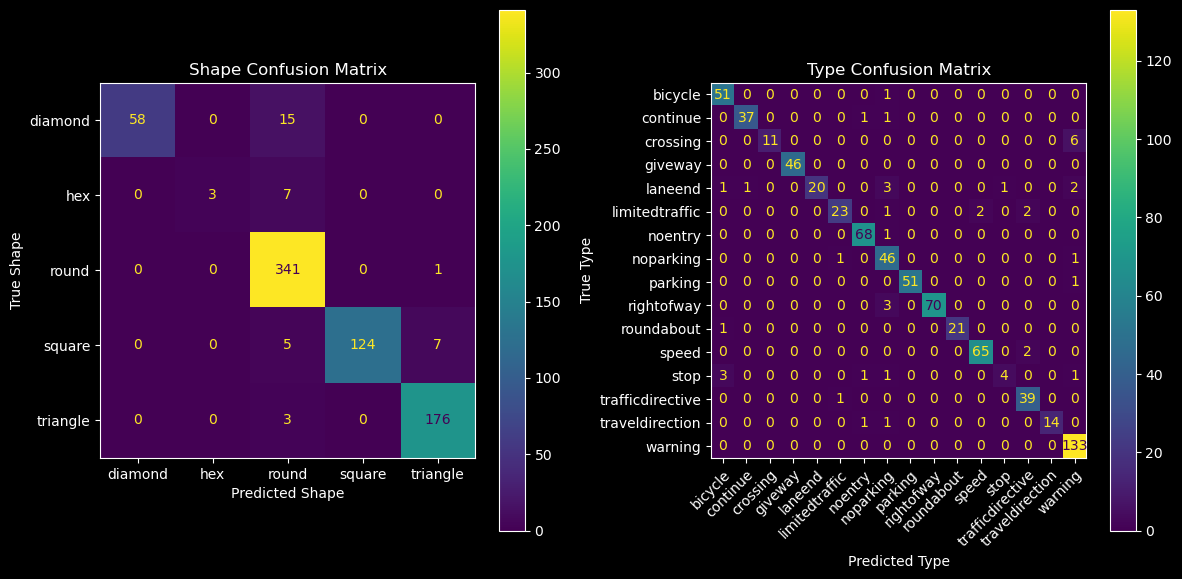

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create the hypertuned Gradient Boosting classifiers with the best parameters
shape_gb_best = GradientBoostingClassifier(**shape_random_search.best_params_, random_state=42)
type_gb_best = GradientBoostingClassifier(**type_random_search.best_params_, random_state=42)

# Train the hypertuned Gradient Boosting classifiers
shape_gb_best.fit(X_train, y_train_shape)
type_gb_best.fit(X_train, y_train_type)

# Make predictions on the validation set
shape_pred = shape_gb_best.predict(X_val)
type_pred = type_gb_best.predict(X_val)

# Evaluate the hypertuned Gradient Boosting classifiers on the validation set
shape_acc = shape_gb_best.score(X_val, y_val_shape)
type_acc = type_gb_best.score(X_val, y_val_type)

print("Shape Accuracy:", shape_acc)
print("Type Accuracy:", type_acc)

# Create confusion matrices
shape_cm = confusion_matrix(y_val_shape, shape_pred)
type_cm = confusion_matrix(y_val_type, type_pred)

# Plot the confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(shape_cm, display_labels=shape_encoder.classes_).plot(ax=ax1)
ax1.set_title("Shape Confusion Matrix")
ax1.set_xlabel("Predicted Shape")
ax1.set_ylabel("True Shape")

ConfusionMatrixDisplay(type_cm, display_labels=type_encoder.classes_).plot(ax=ax2)
ax2.set_title("Type Confusion Matrix")
ax2.set_xlabel("Predicted Type")
ax2.set_ylabel("True Type")

# Rotate the x-axis labels of the Type Confusion Matrix
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.show()

# MLP

In [13]:
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df.iloc[train_indices],
    x_col='image_path',
    y_col=['shape_label', 'type_label'],
    target_size=img_size,
    batch_size=32,
    class_mode='multi_output'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df.iloc[val_indices],
    x_col='image_path',
    y_col=['shape_label', 'type_label'],
    target_size=img_size,
    batch_size=32,
    class_mode='multi_output'
)

# Define the input shape and number of classes
input_shape = (28, 28, 3)
num_shape_classes = len(shape_encoder.classes_)
num_type_classes = len(type_encoder.classes_)

# Create the model architecture
inputs = keras.Input(shape=input_shape)
x = Flatten()(inputs)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layers for shape and type
shape_output = Dense(num_shape_classes, activation='softmax', name='shape')(x)
type_output = Dense(num_type_classes, activation='softmax', name='type')(x)

# Create the model
model = Model(inputs=inputs, outputs=[shape_output, type_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'shape': 'sparse_categorical_crossentropy',
                    'type': 'sparse_categorical_crossentropy'},
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_indices) // 32,
    validation_data=val_generator,
    validation_steps=np.ceil(len(val_indices) / 32).astype(int),
    epochs=10
)

Found 2959 validated image filenames.
Found 740 validated image filenames.
Epoch 1/10


2024-05-05 12:08:57.070420: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2024-05-05 12:08:57.212631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - ETA: 0s - loss: 3.6777 - shape_loss: 1.2115 - type_loss: 2.4662 - shape_accuracy: 0.5374 - type_accuracy: 0.2607

2024-05-05 12:09:01.022384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - 5s 47ms/step - loss: 3.6777 - shape_loss: 1.2115 - type_loss: 2.4662 - shape_accuracy: 0.5374 - type_accuracy: 0.2607 - val_loss: 2.6192 - val_shape_loss: 0.8011 - val_type_loss: 1.8181 - val_shape_accuracy: 0.7405 - val_type_accuracy: 0.4770
Epoch 2/10
92/92 [==============================] - 6s 60ms/step - loss: 2.4304 - shape_loss: 0.7509 - type_loss: 1.6795 - shape_accuracy: 0.7195 - type_accuracy: 0.4909 - val_loss: 1.6661 - val_shape_loss: 0.5064 - val_type_loss: 1.1597 - val_shape_accuracy: 0.8392 - val_type_accuracy: 0.7243
Epoch 3/10
92/92 [==============================] - 4s 40ms/step - loss: 1.9168 - shape_loss: 0.5640 - type_loss: 1.3527 - shape_accuracy: 0.8066 - type_accuracy: 0.5856 - val_loss: 1.3584 - val_shape_loss: 0.4103 - val_type_loss: 0.9481 - val_shape_accuracy: 0.8703 - val_type_accuracy: 0.7081
Epoch 4/10
92/92 [==============================] - 4s 40ms/step - loss: 1.6293 - shape_loss: 0.4812 - type_loss: 1.1482 - sha

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">Convolutional Neural Network</h1>

In [ ]:
add regularization, dropouts, kernel, input reduction, filters, etc. 
try transfer learning - then you can do finetuning.
do hyperparameter tuning using gridsearch on CNN
add an explicit MLP baseline,

and then make a CNN based on the paper

In [22]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.models import Model
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df.iloc[train_indices],
    x_col='image_path',
    y_col=['shape_label', 'type_label'],
    target_size=img_size,
    batch_size=32,
    class_mode='multi_output'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df.iloc[val_indices],
    x_col='image_path',
    y_col=['shape_label', 'type_label'],
    target_size=img_size,
    batch_size=32,
    class_mode='multi_output'
)

# Define the input shape and number of classes
input_shape = (28, 28, 3)
num_shape_classes = len(shape_encoder.classes_)
num_type_classes = len(type_encoder.classes_)

# Create the model architecture
inputs = keras.Input(shape=input_shape)
x = Conv2D(16, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)

# Output layers for shape and type
shape_output = Dense(num_shape_classes, activation='softmax', name='shape')(x)
type_output = Dense(num_type_classes, activation='softmax', name='type')(x)

# Create the model
model = Model(inputs=inputs, outputs=[shape_output, type_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'shape': 'sparse_categorical_crossentropy',
                    'type': 'sparse_categorical_crossentropy'},
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_indices) // 32,
    validation_data=val_generator,
    validation_steps=np.ceil(len(val_indices) / 32).astype(int),
    epochs=20
)

Found 2959 validated image filenames.
Found 740 validated image filenames.
Epoch 1/20


2024-04-30 19:01:18.322296: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2024-04-30 19:01:18.452840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - ETA: 0s - loss: 2.9614 - shape_loss: 0.9322 - type_loss: 2.0293 - shape_accuracy: 0.6823 - type_accuracy: 0.3915

2024-04-30 19:01:39.764433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - 22s 235ms/step - loss: 2.9614 - shape_loss: 0.9322 - type_loss: 2.0293 - shape_accuracy: 0.6823 - type_accuracy: 0.3915 - val_loss: 1.7100 - val_shape_loss: 0.5144 - val_type_loss: 1.1956 - val_shape_accuracy: 0.8541 - val_type_accuracy: 0.7095
Epoch 2/20
92/92 [==============================] - 27s 298ms/step - loss: 1.0698 - shape_loss: 0.3272 - type_loss: 0.7427 - shape_accuracy: 0.9101 - type_accuracy: 0.8066 - val_loss: 0.7334 - val_shape_loss: 0.2232 - val_type_loss: 0.5102 - val_shape_accuracy: 0.9432 - val_type_accuracy: 0.8554
Epoch 3/20
92/92 [==============================] - 26s 285ms/step - loss: 0.5299 - shape_loss: 0.1572 - type_loss: 0.3727 - shape_accuracy: 0.9563 - type_accuracy: 0.9060 - val_loss: 0.4875 - val_shape_loss: 0.1354 - val_type_loss: 0.3520 - val_shape_accuracy: 0.9689 - val_type_accuracy: 0.9054
Epoch 4/20
92/92 [==============================] - 25s 272ms/step - loss: 0.3272 - shape_loss: 0.0962 - type_loss: 0.23

In [ ]:
tester

In [15]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df.iloc[train_indices],
    x_col='image_path',
    y_col=['shape_label', 'type_label'],
    target_size=img_size,
    batch_size=32,
    class_mode='multi_output'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df.iloc[val_indices],
    x_col='image_path',
    y_col=['shape_label', 'type_label'],
    target_size=img_size,
    batch_size=32,
    class_mode='multi_output'
)

# Define the input shape and number of classes
input_shape = (28, 28, 3)
num_shape_classes = len(shape_encoder.classes_)
num_type_classes = len(type_encoder.classes_)

# Create the model architecture
inputs = keras.Input(shape=input_shape)
x = Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(inputs)
x = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(x)
x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)

# Output layers for shape and type
shape_output = Dense(num_shape_classes, activation='softmax', name='shape')(x)
type_output = Dense(num_type_classes, activation='softmax', name='type')(x)

# Create the model
model = Model(inputs=inputs, outputs=[shape_output, type_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'shape': 'sparse_categorical_crossentropy',
                    'type': 'sparse_categorical_crossentropy'},
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_indices) // 32,
    validation_data=val_generator,
    validation_steps=np.ceil(len(val_indices) / 32).astype(int),
    epochs=20
)

Found 2959 validated image filenames.
Found 740 validated image filenames.
Epoch 1/20


2024-05-05 13:08:14.609569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - ETA: 0s - loss: 1.4938 - shape_loss: 0.3285 - type_loss: 0.7641 - shape_accuracy: 0.8873 - type_accuracy: 0.7790

2024-05-05 13:08:39.702887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - 26s 268ms/step - loss: 1.4938 - shape_loss: 0.3285 - type_loss: 0.7641 - shape_accuracy: 0.8873 - type_accuracy: 0.7790 - val_loss: 3.2408 - val_shape_loss: 1.0002 - val_type_loss: 1.8498 - val_shape_accuracy: 0.9176 - val_type_accuracy: 0.6716
Epoch 2/20
92/92 [==============================] - 24s 258ms/step - loss: 0.5168 - shape_loss: 0.0323 - type_loss: 0.1059 - shape_accuracy: 0.9904 - type_accuracy: 0.9734 - val_loss: 2.0443 - val_shape_loss: 0.5120 - val_type_loss: 1.1675 - val_shape_accuracy: 0.9730 - val_type_accuracy: 0.8784
Epoch 3/20
92/92 [==============================] - 28s 309ms/step - loss: 0.4156 - shape_loss: 0.0154 - type_loss: 0.0496 - shape_accuracy: 0.9959 - type_accuracy: 0.9846 - val_loss: 1.2652 - val_shape_loss: 0.3324 - val_type_loss: 0.5968 - val_shape_accuracy: 0.9932 - val_type_accuracy: 0.9676
Epoch 4/20
92/92 [==============================] - 26s 278ms/step - loss: 0.3599 - shape_loss: 0.0057 - type_loss: 0.03

1/1 [==============================] - 0s 140ms/step
Confusion matrices created.


<Figure size 800x600 with 0 Axes>

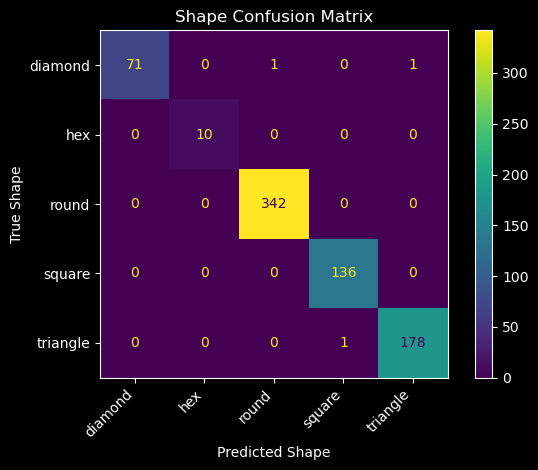

<Figure size 800x600 with 0 Axes>

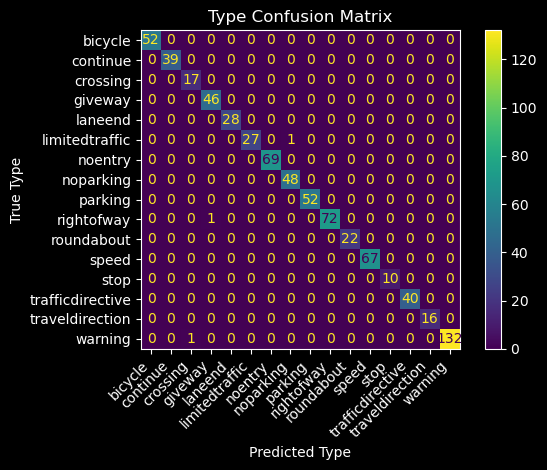

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize empty lists to store the true labels and predicted labels
shape_true_labels = []
type_true_labels = []
shape_pred_labels = []
type_pred_labels = []

# Specify the number of batches to process
num_batches = 24  # Process 24 batches (740 images with batch size 32)

# Iterate over the validation data in batches
batch_count = 0
for batch_data, batch_labels in val_generator:
    # Generate predictions for the current batch
    batch_preds = model.predict(batch_data)
    shape_preds = np.argmax(batch_preds[0], axis=1)
    type_preds = np.argmax(batch_preds[1], axis=1)

    # Append the true labels and predicted labels to the lists
    shape_true_labels.extend(batch_labels[0])
    type_true_labels.extend(batch_labels[1])
    shape_pred_labels.extend(shape_preds)
    type_pred_labels.extend(type_preds)

    batch_count += 1
    if batch_count >= num_batches:
        break  # Exit the loop after processing the specified number of batches

# Map the predicted labels back to their original names
shape_labels_map = {i: label for i, label in enumerate(shape_encoder.classes_)}
type_labels_map = {i: label for i, label in enumerate(type_encoder.classes_)}

# Create confusion matrices for shape and type
shape_cm = confusion_matrix(shape_true_labels, shape_pred_labels)
type_cm = confusion_matrix(type_true_labels, type_pred_labels)

print("Confusion matrices created.")

# Plot the confusion matrix for shape
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(shape_cm, display_labels=shape_encoder.classes_).plot()
plt.title("Shape Confusion Matrix")
plt.xlabel("Predicted Shape")
plt.ylabel("True Shape")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Plot the confusion matrix for type
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(type_cm, display_labels=type_encoder.classes_).plot()
plt.title("Type Confusion Matrix")
plt.xlabel("Predicted Type")
plt.ylabel("True Type")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

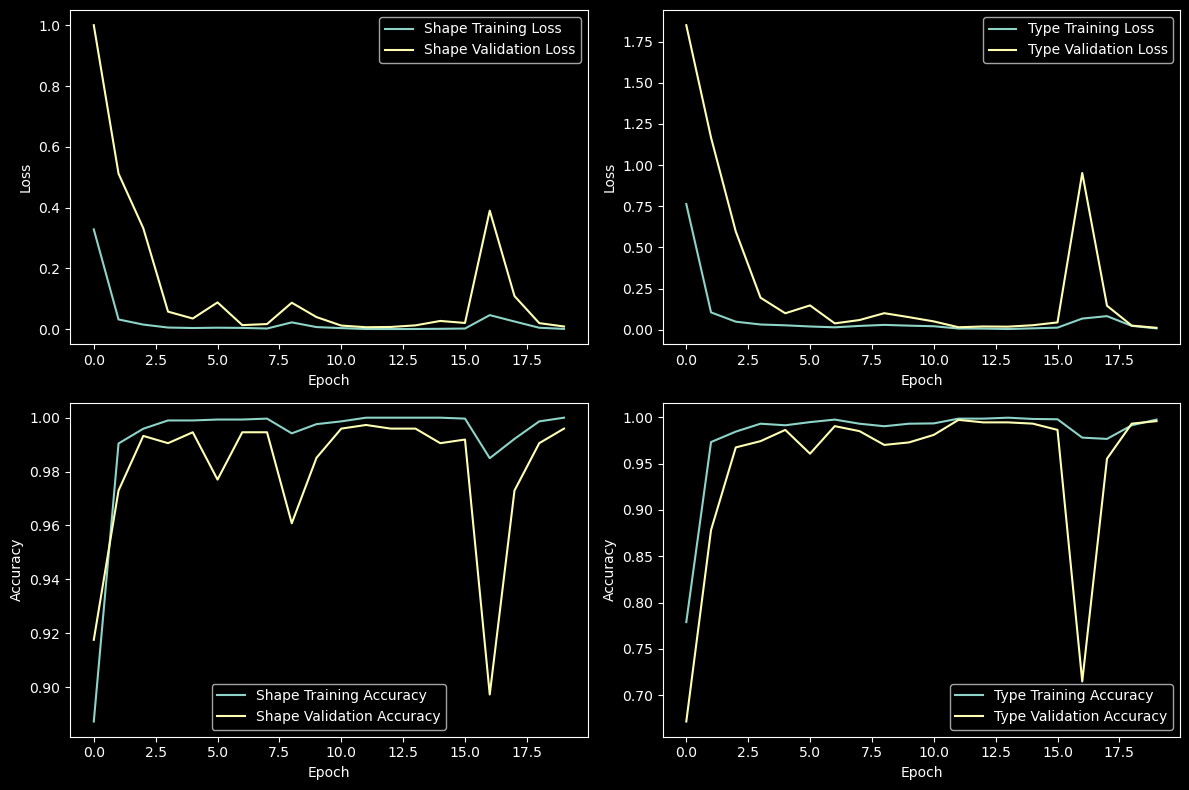

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Plot the learning curves
plt.figure(figsize=(12, 8))

# Plot loss curves
plt.subplot(2, 2, 1)
plt.plot(history.history['shape_loss'], label='Shape Training Loss')
plt.plot(history.history['val_shape_loss'], label='Shape Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['type_loss'], label='Type Training Loss')
plt.plot(history.history['val_type_loss'], label='Type Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy curves
plt.subplot(2, 2, 3)
plt.plot(history.history['shape_accuracy'], label='Shape Training Accuracy')
plt.plot(history.history['val_shape_accuracy'], label='Shape Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history.history['type_accuracy'], label='Type Training Accuracy')
plt.plot(history.history['val_type_accuracy'], label='Type Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
loss and learning rate in report

SyntaxError: invalid syntax (2963133039.py, line 1)

In [18]:
# Evaluate the model on the validation set
val_loss, val_shape_loss, val_type_loss, val_shape_acc, val_type_acc = model.evaluate(val_generator, steps=len(val_indices) // 32)

# Print the validation metrics
print("Validation Loss:", val_loss)
print("Validation Shape Loss:", val_shape_loss)
print("Validation Type Loss:", val_type_loss)
print("Validation Shape Accuracy:", val_shape_acc)
print("Validation Type Accuracy:", val_type_acc)

 9/23 [==========>...................] - ETA: 0s - loss: 0.1549 - shape_loss: 0.0042 - type_loss: 0.0123 - shape_accuracy: 1.0000 - type_accuracy: 0.9965

2024-05-05 13:19:25.415692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 0s 18ms/step - loss: 0.1599 - shape_loss: 0.0092 - type_loss: 0.0125 - shape_accuracy: 0.9959 - type_accuracy: 0.9959
Validation Loss: 0.15993283689022064
Validation Shape Loss: 0.009151759557425976
Validation Type Loss: 0.012470233254134655
Validation Shape Accuracy: 0.9959239363670349
Validation Type Accuracy: 0.9959239363670349


In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d_19 (Conv2D)             (None, 26, 26, 16)   448         ['input_4[0][0]']                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 24, 24, 32)   4640        ['conv2d_19[0][0]']              
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 12, 12, 32)  0           ['conv2d_20[0][0]']              
                                                                                              

1/1 [==============================] - 0s 53ms/step


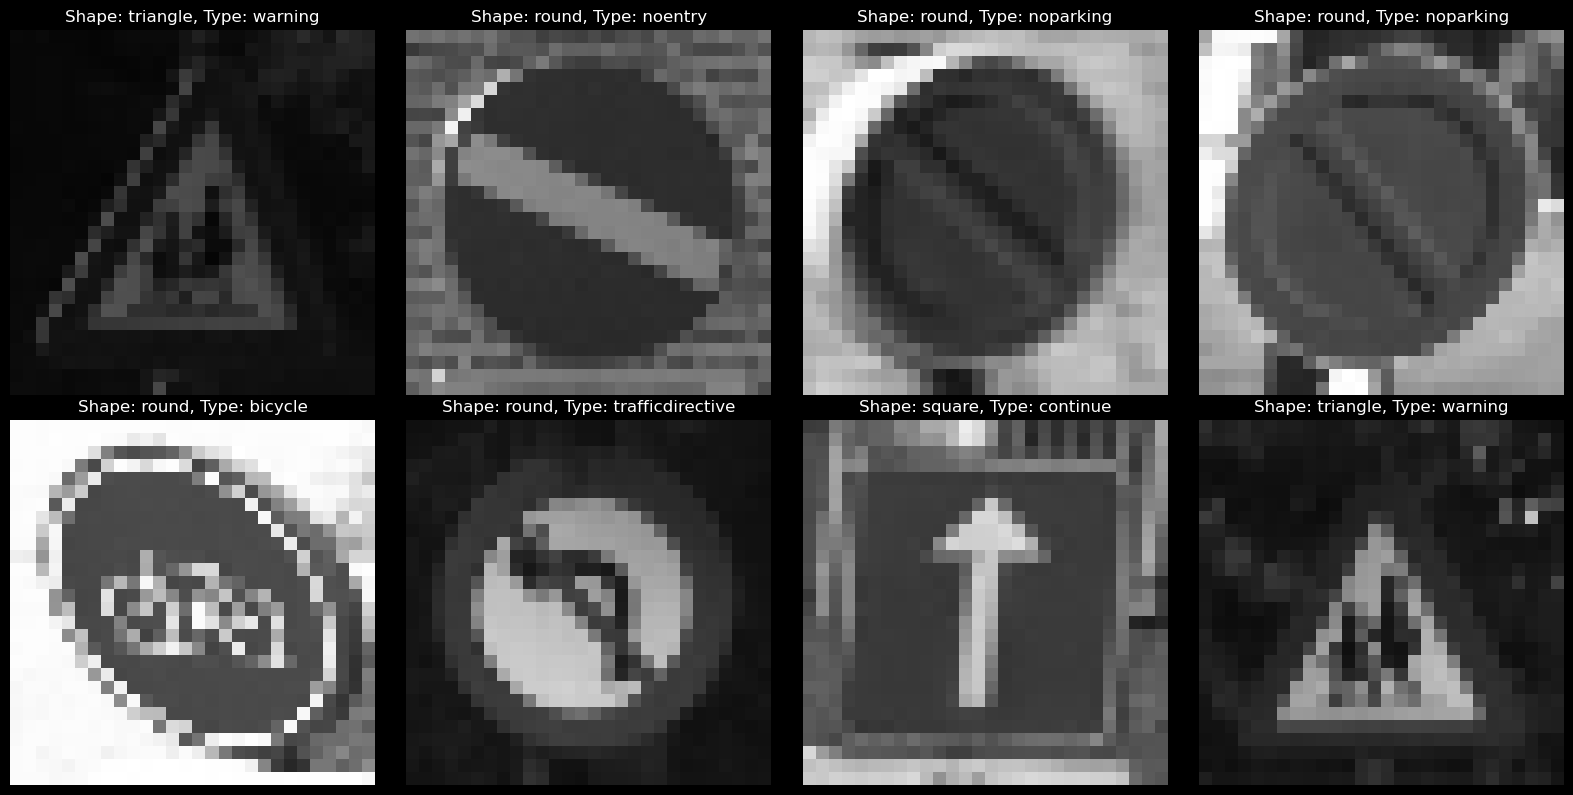

In [20]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Create a figure with 2 rows and 4 columns
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

# Loop through 8 random examples
for i in range(8):
    # Select a random image path from the validation set
    random_index = np.random.choice(val_indices)
    image_path = df.iloc[random_index]['image_path']
    
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Make predictions
    shape_pred, type_pred = model.predict(x)
    
    # Get the predicted shape and type labels
    shape_label = shape_encoder.inverse_transform([np.argmax(shape_pred)])[0]
    type_label = type_encoder.inverse_transform([np.argmax(type_pred)])[0]
    
    # Display the tested image
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Shape: {shape_label}, Type: {type_label}")

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()

# KNN & ISODATA & MAXIMUM-LIKELIHOOD, 

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">Independent Evaluation</h1>

In [21]:
-BEST IDEA IS TO GATHER INCORRECT, AND CORRECT DATA TO TEST.
we used both the german sister dataset, and collected 200 of my own images


SyntaxError: invalid syntax (1473448344.py, line 1)

In [22]:
print("\nValidation set counts:")
print("Shape labels:")
print(df.loc[val_indices, 'shape_label'].map(dict(enumerate(shape_labels))).value_counts())
print("\nType labels:")
print(df.loc[val_indices, 'type_label'].map(dict(enumerate(type_labels))).value_counts())


Validation set counts:
Shape labels:
shape_label
square      342
triangle    179
round       136
hex          73
diamond      10
Name: count, dtype: int64

Type labels:
type_label
giveway             133
bicycle              73
trafficdirective     69
roundabout           67
noentry              52
stop                 52
speed                48
continue             46
noparking            40
rightofway           39
crossing             28
parking              28
limitedtraffic       22
laneend              17
warning              16
traveldirection      10
Name: count, dtype: int64


In [34]:
import os
from PIL import Image

def process_images(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Get the file extension
            _, extension = os.path.splitext(file)
            
            # Check if the file is an image
            if extension.lower() in ['.png','.ppm']:
                # Construct the full file paths
                input_path = os.path.join(root, file)
                output_path = os.path.join(root, os.path.splitext(file)[0] + '.png')
                
                try:
                    # Open the image file
                    with Image.open(input_path) as img:
                        # Resize the image to 28x28 pixels
                        resized_img = img.resize((28, 28))
                        
                        # Convert the image to black and white
                        bw_img = resized_img.convert('L')
                        
                        # Save the black and white image with the new ".png" extension
                        bw_img.save(output_path)

                except Exception as e:
                    print(f"Error processing {input_path}: {str(e)}")

# Directory to start the recursive processing
directory = "independent_dataset"

# Call the function to process the images
process_images(directory)

In [43]:
test_dataset_path = 'independent_dataset'
# change to 32 to test transfer learning
img_size = (28, 28)

Number of image files found: 677


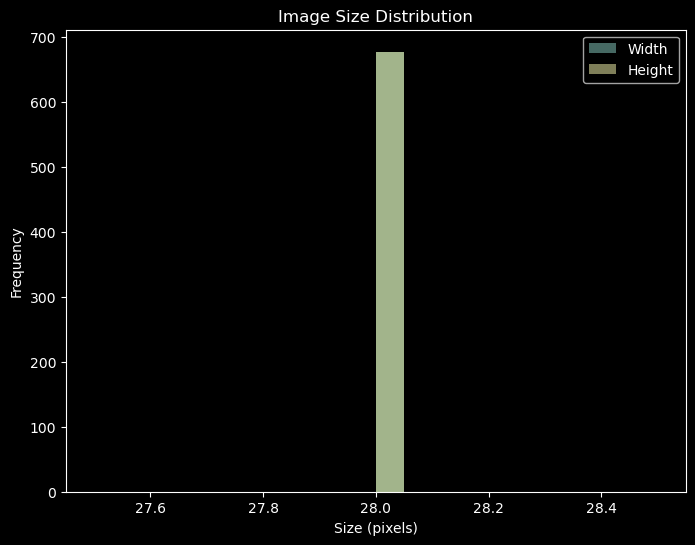

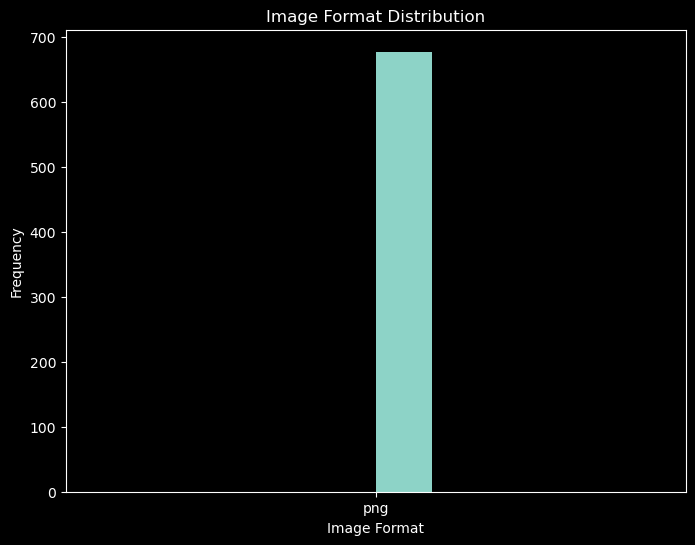

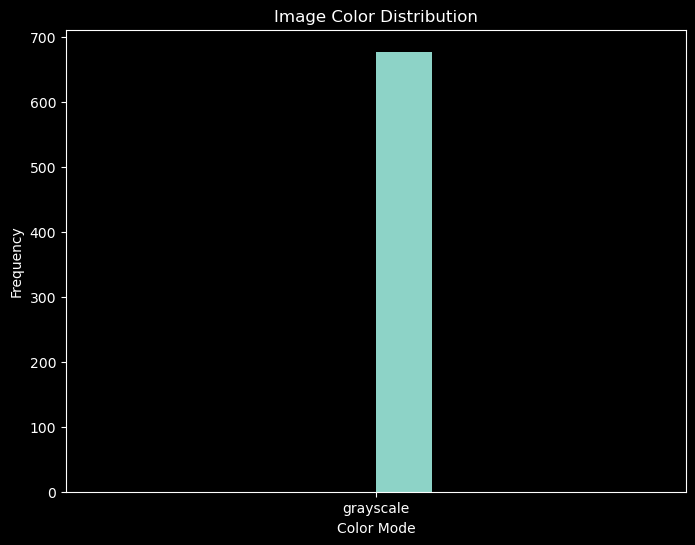

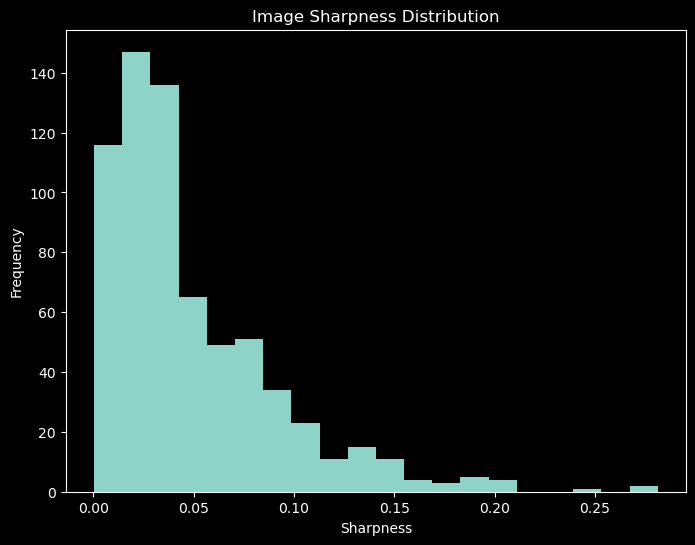

In [58]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters

# Directory containing the image dataset
dataset_dir = 'independent_dataset'

# Function to get all image files in subdirectories
def get_image_files(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('.png')):
                image_files.append(os.path.join(root, file))
    return image_files

# Get the list of image files
image_files = get_image_files(dataset_dir)

print("Number of image files found:", len(image_files))

# Initialize lists to store image properties
image_sizes = []
image_formats = []
image_colors = []
image_sharpness = []

# Iterate over the image files
for image_path in image_files:
    try:
        image = io.imread(image_path)
        
        # Get image size
        height, width = image.shape[:2]
        image_sizes.append((width, height))
        
        # Get image format
        image_format = os.path.splitext(image_path)[1][1:]
        image_formats.append(image_format)
        
        # Check if the image is grayscale or color
        if len(image.shape) == 2:
            image_colors.append('grayscale')
        else:
            image_colors.append('color')
        
        # Calculate image sharpness using the variance of the Laplacian
        sharpness = np.var(filters.laplace(image))
        image_sharpness.append(sharpness)
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")

# Plot image size distribution
plt.figure(figsize=(8, 6))
plt.hist([size[0] for size in image_sizes], bins=20, alpha=0.5, label='Width')
plt.hist([size[1] for size in image_sizes], bins=20, alpha=0.5, label='Height')
plt.xlabel('Size (pixels)')
plt.ylabel('Frequency')
plt.title('Image Size Distribution')
plt.legend()
plt.show()

# Plot image format distribution
plt.figure(figsize=(8, 6))
plt.hist(image_formats)
plt.xlabel('Image Format')
plt.ylabel('Frequency')
plt.title('Image Format Distribution')
plt.show()

# Plot image color distribution
plt.figure(figsize=(8, 6))
plt.hist(image_colors)
plt.xlabel('Color Mode')
plt.ylabel('Frequency')
plt.title('Image Color Distribution')
plt.show()

# Plot image sharpness distribution
plt.figure(figsize=(8, 6))
plt.hist(image_sharpness, bins=20)
plt.xlabel('Sharpness')
plt.ylabel('Frequency')
plt.title('Image Sharpness Distribution')
plt.show()

Number of images in the test set: 677


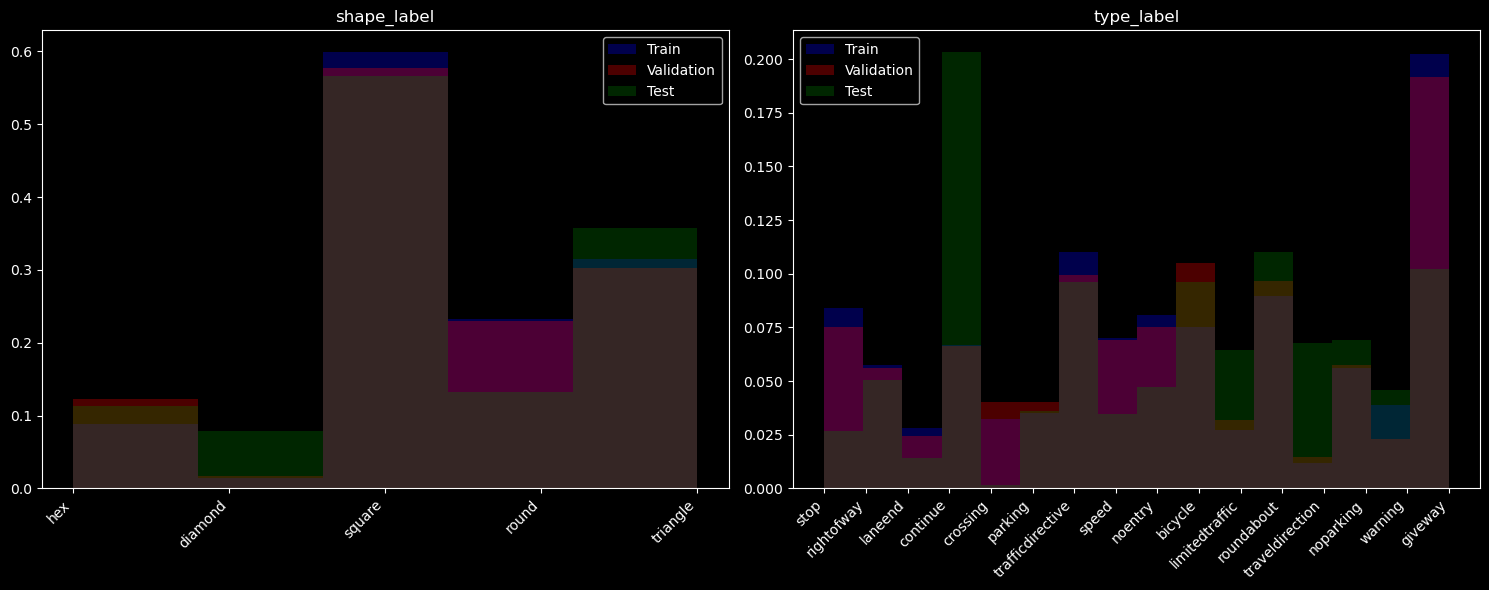

In [44]:
# Create lists to store the image paths, shapes, and types for the test dataset
test_image_paths = []
test_shapes = []
test_types = []

for shape in os.listdir(test_dataset_path):
    shape_path = os.path.join(test_dataset_path, shape)
    for sign_type in os.listdir(shape_path):
        type_path = os.path.join(shape_path, sign_type)
        for image_file in os.listdir(type_path):
            image_path = os.path.join(type_path, image_file)
            test_image_paths.append(image_path)
            test_shapes.append(shape)
            test_types.append(sign_type)

# Encode the shape and type labels for the test dataset
test_shape_labels = shape_encoder.transform(test_shapes)
test_type_labels = type_encoder.transform(test_types)

# Create a DataFrame with image paths, shape labels, and type labels for the test dataset
test_df = pd.DataFrame({
    'image_path': test_image_paths,
    'shape_label': test_shape_labels,
    'type_label': test_type_labels
})

# Print the number of items in the test dataset
print("Number of images in the test set:", len(test_df))

# Create a data generator for the test dataset
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Update the histogram plotting code to include the test dataset
plt.figure(figsize=(15, 6))
for i, col in enumerate(['shape_label', 'type_label']):
    plt.subplot(1, 2, i+1)
    if col == 'shape_label':
        unique_values = shape_labels
    else:
        unique_values = type_labels
    plt.hist(df.loc[train_indices, col], alpha=0.3, color='b', density=True,
             bins=len(unique_values), label='Train')
    plt.hist(df.loc[val_indices, col], alpha=0.3, color='r', density=True,
             bins=len(unique_values), label='Validation')
    plt.hist(test_df[col], alpha=0.3, color='g', density=True,
             bins=len(unique_values), label='Test')
    plt.title(col)
    plt.xticks(range(len(unique_values)), unique_values, rotation=45, ha='right')
    plt.legend()

plt.tight_layout()
plt.show()

Found 677 validated image filenames.
1/1 [==============================] - 0s 35ms/step
Confusion matrices created.
Classification Report - Shape:
              precision    recall  f1-score   support

     diamond       0.00      0.00      0.00        61
         hex       0.00      0.00      0.00        11
       round       0.46      0.78      0.58       307
      square       0.00      0.00      0.00        72
    triangle       0.41      0.14      0.21       194

    accuracy                           0.41       645
   macro avg       0.17      0.18      0.16       645
weighted avg       0.34      0.41      0.34       645

Classification Report - Type:
                  precision    recall  f1-score   support

         bicycle       0.00      0.00      0.00        17
        continue       0.00      0.00      0.00        32
        crossing       0.00      0.00      0.00         9
         giveway       0.29      0.27      0.28       129
         laneend       0.00      0.00     

<Figure size 800x600 with 0 Axes>

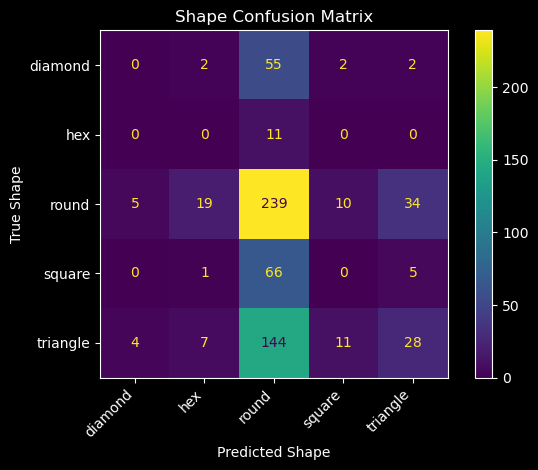

<Figure size 800x600 with 0 Axes>

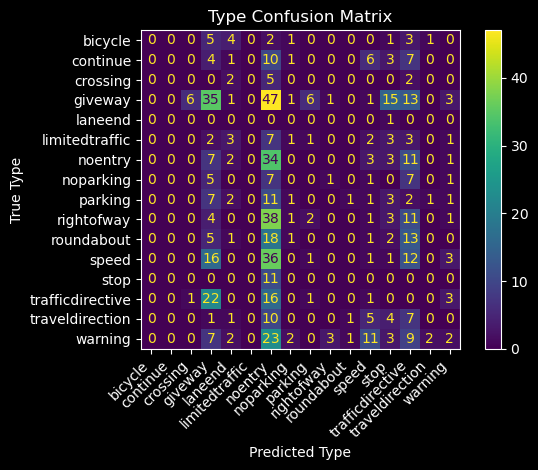

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Initialize empty lists to store the true labels and predicted labels
shape_true_labels = []
type_true_labels = []
shape_pred_labels = []
type_pred_labels = []

# Specify the number of batches to process
num_batches = len(test_df) // 32  # Process all batches in the test dataset

# Create a generator for the test data
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col=None,
    target_size=img_size,
    batch_size=32,
    shuffle=False,
    class_mode=None
)

# Iterate over the test data in batches
batch_count = 0
for batch_data in test_generator:
    # Generate predictions for the current batch
    batch_preds = model.predict(batch_data)
    shape_preds = np.argmax(batch_preds[0], axis=1)
    type_preds = np.argmax(batch_preds[1], axis=1)

    # Get the corresponding true labels for the current batch
    start_index = test_generator.batch_index * test_generator.batch_size
    end_index = start_index + test_generator.batch_size
    batch_shape_labels = test_df['shape_label'].iloc[start_index:end_index].values
    batch_type_labels = test_df['type_label'].iloc[start_index:end_index].values

    # Append the true labels and predicted labels to the lists
    shape_true_labels.extend(batch_shape_labels)
    type_true_labels.extend(batch_type_labels)
    shape_pred_labels.extend(shape_preds)
    type_pred_labels.extend(type_preds)

    batch_count += 1
    if batch_count >= num_batches:
        break  # Exit the loop after processing all batches in the test dataset

# Ensure the lengths of true and predicted labels are the same
min_length = min(len(shape_true_labels), len(shape_pred_labels))
shape_true_labels = shape_true_labels[:min_length]
shape_pred_labels = shape_pred_labels[:min_length]
type_true_labels = type_true_labels[:min_length]
type_pred_labels = type_pred_labels[:min_length]

# Map the predicted labels back to their original names
shape_labels_map = {i: label for i, label in enumerate(shape_encoder.classes_)}
type_labels_map = {i: label for i, label in enumerate(type_encoder.classes_)}

# Create confusion matrices for shape and type
shape_cm = confusion_matrix(shape_true_labels, shape_pred_labels)
type_cm = confusion_matrix(type_true_labels, type_pred_labels)

print("Confusion matrices created.")

# Generate classification report for shape
print("Classification Report - Shape:")
print(classification_report(shape_true_labels, shape_pred_labels, target_names=shape_encoder.classes_))

# Generate classification report for type
print("Classification Report - Type:")
print(classification_report(type_true_labels, type_pred_labels, target_names=type_encoder.classes_))

# Plot the confusion matrix for shape
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(shape_cm, display_labels=shape_encoder.classes_).plot()
plt.title("Shape Confusion Matrix")
plt.xlabel("Predicted Shape")
plt.ylabel("True Shape")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Plot the confusion matrix for type
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(type_cm, display_labels=type_encoder.classes_).plot()
plt.title("Type Confusion Matrix")
plt.xlabel("Predicted Type")
plt.ylabel("True Type")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 61ms/step


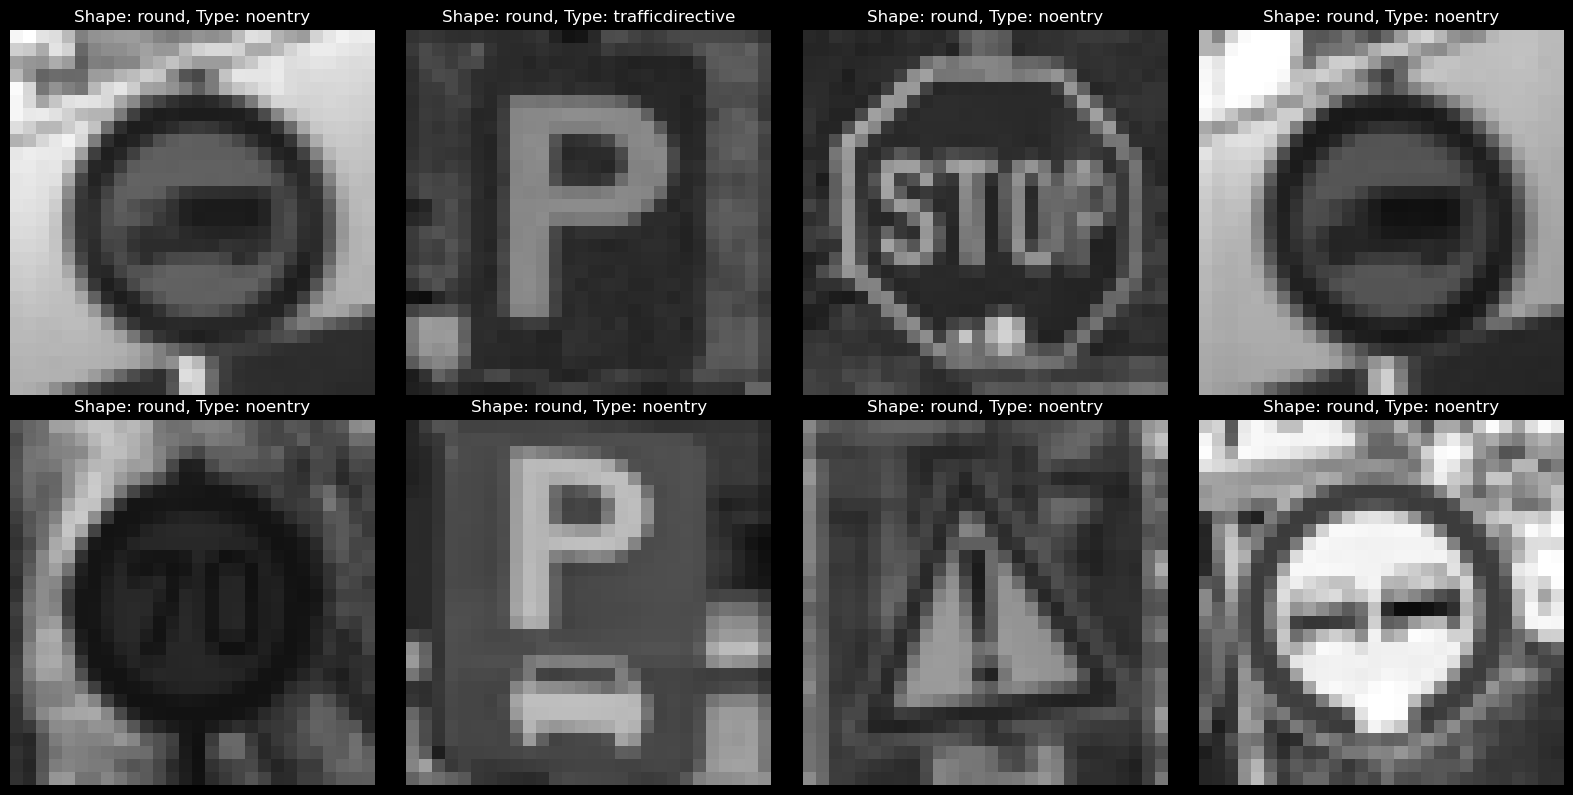

In [46]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with 2 rows and 4 columns
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

# Loop through 8 random examples
for i in range(8):
    # Select a random image path from the test set
    random_index = np.random.choice(len(test_df))
    image_path = test_df.iloc[random_index]['image_path']
    
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Make predictions
    preds = model.predict(x)
    shape_pred = preds[0]
    type_pred = preds[1]
    
    # Get the predicted shape and type labels
    shape_label = shape_encoder.inverse_transform([np.argmax(shape_pred)])[0]
    type_label = type_encoder.inverse_transform([np.argmax(type_pred)])[0]
    
    # Display the tested image
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Shape: {shape_label}, Type: {type_label}")

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 37ms/step


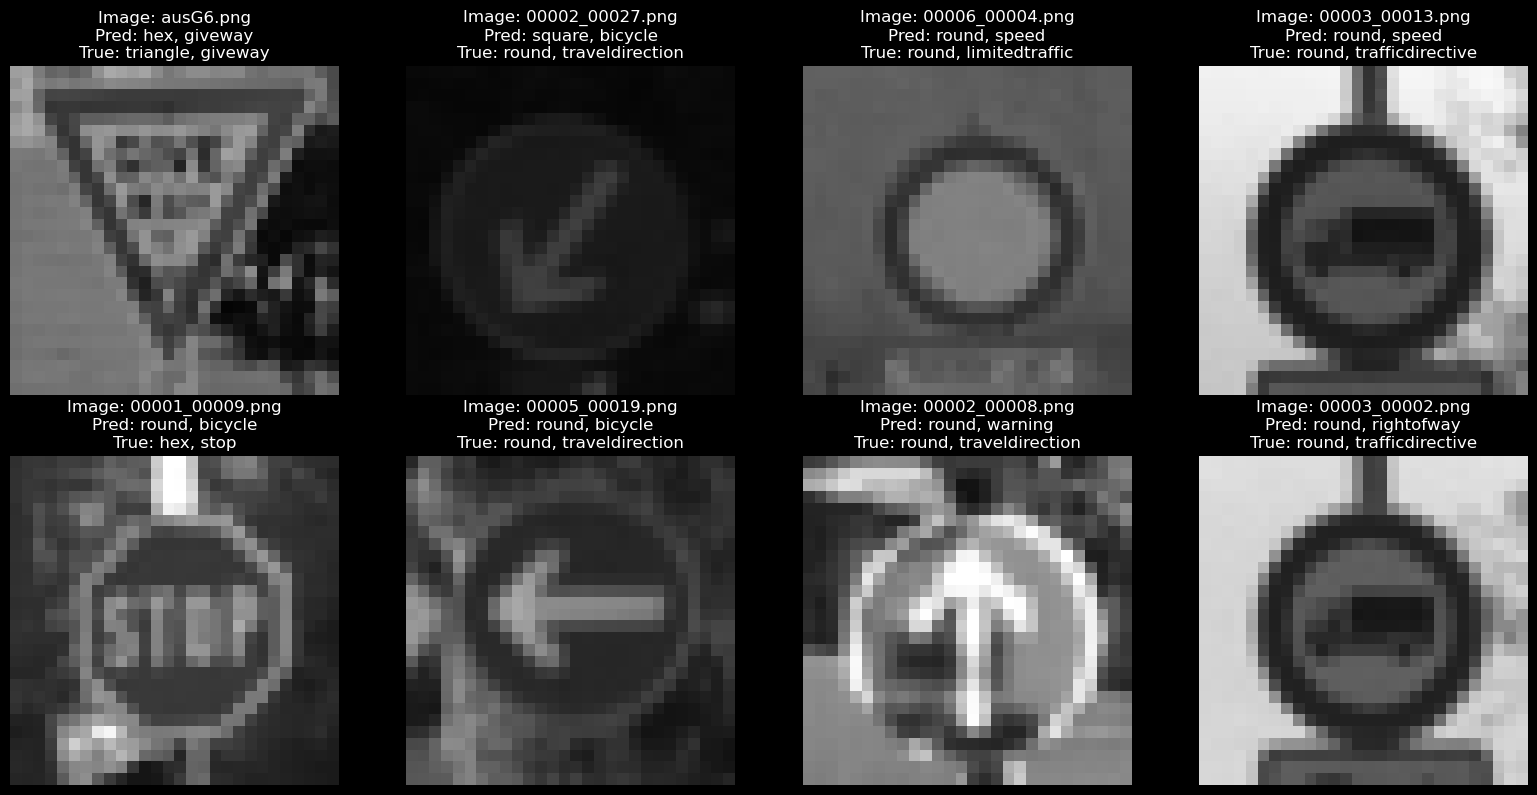

In [33]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

# Create a figure with 2 rows and 4 columns
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

# Initialize a counter for wrongly classified images
wrong_counter = 0

# Loop until we find 8 wrongly classified images
while wrong_counter < 8:
    # Select a random image path from the test set
    random_index = np.random.choice(len(test_df))
    image_path = test_df.iloc[random_index]['image_path']
    
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Make predictions
    preds = model.predict(x)
    shape_pred = preds[0]
    type_pred = preds[1]
    
    # Get the predicted shape and type labels
    shape_label = shape_encoder.inverse_transform([np.argmax(shape_pred)])[0]
    type_label = type_encoder.inverse_transform([np.argmax(type_pred)])[0]
    
    # Get the true shape and type labels
    true_shape_label = shape_encoder.inverse_transform([test_df.iloc[random_index]['shape_label']])[0]
    true_type_label = type_encoder.inverse_transform([test_df.iloc[random_index]['type_label']])[0]
    
    # Check if the predicted labels match the true labels
    if shape_label != true_shape_label or type_label != true_type_label:
        # Extract the image name from the image path
        image_name = os.path.basename(image_path)
        
        # Display the wrongly classified image with the image name
        axes[wrong_counter].imshow(img)
        axes[wrong_counter].axis('off')
        axes[wrong_counter].set_title(f"Image: {image_name}\nPred: {shape_label}, {type_label}\nTrue: {true_shape_label}, {true_type_label}")
        wrong_counter += 1

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()

In [34]:
# Transfer Learning

In [36]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df.iloc[train_indices],
    x_col='image_path',
    y_col=['shape_label', 'type_label'],
    target_size=(32, 32),  # Resize to (32, 32)
    batch_size=32,
    class_mode='multi_output'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df.iloc[val_indices],
    x_col='image_path',
    y_col=['shape_label', 'type_label'],
    target_size=(32, 32),  # Resize to (32, 32)
    batch_size=32,
    class_mode='multi_output'
)

Found 2959 validated image filenames.
Found 740 validated image filenames.
58889256/58889256 [==============================] - 18s 0us/step


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(28, 28, 3))

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(28, 28, 3))

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(28, 28, 3))

In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(28, 28, 3))

In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(28, 28, 3))

In [ ]:
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(28, 28, 3))

In [37]:
from keras.applications import VGG16
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

from keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create the model architecture
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)

# Output layers for shape and type
shape_output = Dense(num_shape_classes, activation='softmax', name='shape')(x)
type_output = Dense(num_type_classes, activation='softmax', name='type')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=[shape_output, type_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'shape': 'sparse_categorical_crossentropy',
                    'type': 'sparse_categorical_crossentropy'},
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_indices) // 32,
    validation_data=val_generator,
    validation_steps=np.ceil(len(val_indices) / 32).astype(int),
    epochs=20
)

Epoch 1/20


2024-05-05 13:44:02.281504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - ETA: 0s - loss: 3.5427 - shape_loss: 1.0642 - type_loss: 2.3088 - shape_accuracy: 0.6068 - type_accuracy: 0.3170

2024-05-05 13:44:09.719068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - 9s 81ms/step - loss: 3.5427 - shape_loss: 1.0642 - type_loss: 2.3088 - shape_accuracy: 0.6068 - type_accuracy: 0.3170 - val_loss: 2.8907 - val_shape_loss: 0.8770 - val_type_loss: 1.9606 - val_shape_accuracy: 0.6392 - val_type_accuracy: 0.4270
Epoch 2/20
92/92 [==============================] - 9s 97ms/step - loss: 2.6335 - shape_loss: 0.7831 - type_loss: 1.7868 - shape_accuracy: 0.6908 - type_accuracy: 0.4544 - val_loss: 2.4825 - val_shape_loss: 0.7539 - val_type_loss: 1.6558 - val_shape_accuracy: 0.7014 - val_type_accuracy: 0.4865
Epoch 3/20
92/92 [==============================] - 8s 90ms/step - loss: 2.3899 - shape_loss: 0.7165 - type_loss: 1.5915 - shape_accuracy: 0.7140 - type_accuracy: 0.5056 - val_loss: 2.3274 - val_shape_loss: 0.7040 - val_type_loss: 1.5332 - val_shape_accuracy: 0.7311 - val_type_accuracy: 0.5230
Epoch 4/20
92/92 [==============================] - 7s 78ms/step - loss: 2.2773 - shape_loss: 0.6824 - type_loss: 1.4983 - sha

In [ ]:
# Unsupervised

In [ ]:
K-Means

In [47]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.image import load_img, img_to_array

# Function to load and preprocess images
def load_and_preprocess_image(path):
    img = load_img(path, target_size=(28, 28))
    img_array = img_to_array(img)
    img_array = img_array.flatten()
    return img_array

# Load and preprocess the images
image_paths = df['image_path'].values
X = np.array([load_and_preprocess_image(path) for path in image_paths])

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Specify the number of clusters (k)
k = 5

# Create and fit the k-means model
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)

# Get the cluster labels for each image
labels = kmeans.labels_

# Print the cluster labels
print("Cluster Labels:")
print(labels)

ImportError: cannot import name 'load_img' from 'keras.preprocessing.image' (/opt/anaconda/lib/python3.11/site-packages/keras/preprocessing/image.py)